In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.api import adfuller
from datetime import date
import matplotlib.pyplot as plt

In [103]:
s1 = yf.download('JPM', date(2020, 1, 1), date(2022, 1, 1))
s2 = yf.download('GS', date(2020, 1, 1), date(2022, 1, 1))
ma = 30
data = pd.DataFrame({'s1':s1['Adj Close'], 's2':s2['Adj Close']}, index = s1.index)
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,s1,s2
Date,,
2020-01-02,131.047958,223.544083
2020-01-03,129.318634,220.930099
2020-01-06,129.215805,223.191116
2020-01-07,127.019058,224.660294
2020-01-08,128.009903,226.825882


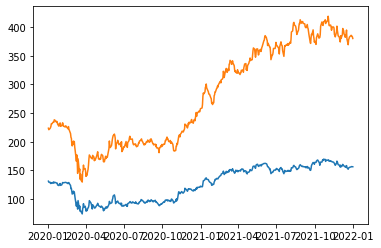

In [104]:
plt.plot(data['s1'])
plt.plot(data['s2'])
plt.show()

In [105]:
X1, X2 = np.log(data['s1']), np.log(data['s2'])
x1 = sm.add_constant(X1)
data['Hedge Ratio'] = RollingOLS(X2, X1, window=ma).fit().params
data['Spread'] = (X2 - data['Hedge Ratio']*X1)

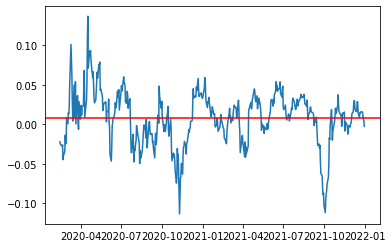

In [106]:
plt.plot(data['Spread'])
plt.axhline(y=data['Spread'].mean(), color='r')
plt.show()

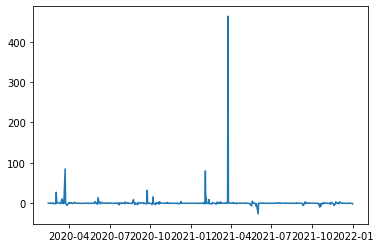

In [107]:
plt.plot(data['Spread'].pct_change())
plt.show()

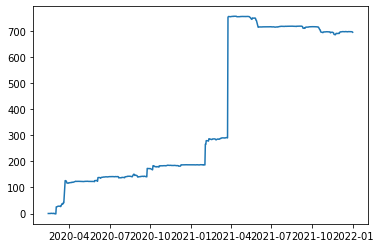

In [108]:
plt.plot(data['Spread'].pct_change().cumsum())
plt.show()

In [109]:
data['Z_Score'] = (data['Spread']-data['Spread'].rolling(window=ma).mean())/data['Spread'].rolling(window=ma).std()

In [110]:
#data['ADF'] = [adfuller(data.iloc[(x-ma):x]['Hedge Ratio'])[0] for x in range(ma, len(data))]
data.head()

,s1,s2,Hedge Ratio,Spread,Z_Score
Date,,,,,
2020-01-02,131.047958,223.544083,NaN,NaN,NaN
2020-01-03,129.318634,220.930099,NaN,NaN,NaN
2020-01-06,129.215805,223.191116,NaN,NaN,NaN
2020-01-07,127.019058,224.660294,NaN,NaN,NaN
2020-01-08,128.009903,226.825882,NaN,NaN,NaN


In [135]:
data['ADF'] = [0 for x in range(ma+ma)] + [adfuller(data.iloc[(x-ma):x]['Hedge Ratio']) for x in range(ma+ma, len(data))]
data['ADF lim'] = [0 for x in range(ma+ma)] + [1 if data.iloc[x]['ADF'][0] < data.iloc[x]['ADF'][4]['10%'] else 0 for x in range(ma+ma, len(data))]

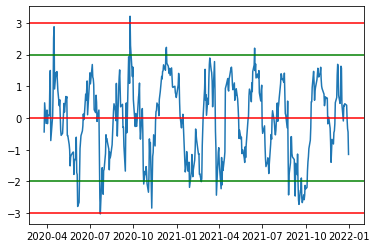

In [136]:
plt.plot(data['Z_Score'])
plt.axhline(y=0, color='r')
plt.axhline(y=2, color='g')
plt.axhline(y=-2, color='g')
plt.axhline(y=3, color='r')
plt.axhline(y=-3, color='r')
plt.show()

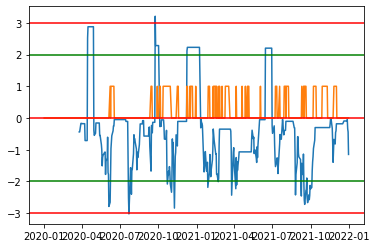

In [137]:
data['Trade periods short'] = data['Z_Score'].where((data['Z_Score'] >= 2)|(data['Z_Score'] <= 0)).ffill()
data['Trade periods long'] = data['Z_Score'].where((data['Z_Score'] <= -2)|(data['Z_Score'] >= 0)).ffill()
plt.plot(data['Trade periods short'])
plt.plot(data['ADF lim'])
plt.axhline(y=0, color='r')
plt.axhline(y=2, color='g')
plt.axhline(y=-2, color='g')
plt.axhline(y=3, color='r')
plt.axhline(y=-3, color='r')
plt.show()

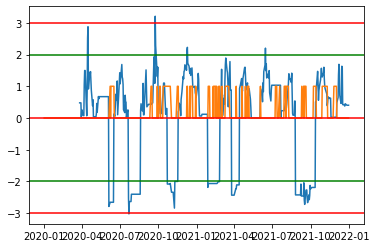

In [138]:
plt.plot(data['Trade periods long'])
plt.plot(data['ADF lim'])
plt.axhline(y=0, color='r')
plt.axhline(y=2, color='g')
plt.axhline(y=-2, color='g')
plt.axhline(y=3, color='r')
plt.axhline(y=-3, color='r')
plt.show()

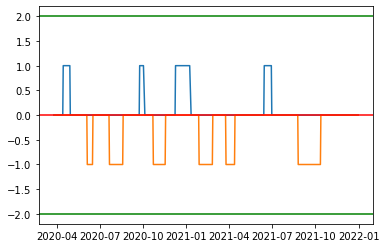

In [139]:
data['Trades short'] = (np.sign(data['Trade periods short'])+1)/2
data['Trades long'] = -(1-(np.sign(data['Trade periods long'])))/2
plt.plot(data['Trades short'])
plt.plot(data['Trades long'])
plt.axhline(y=0, color='r')
plt.axhline(y=2, color='g')
plt.axhline(y=-2, color='g')
plt.show()

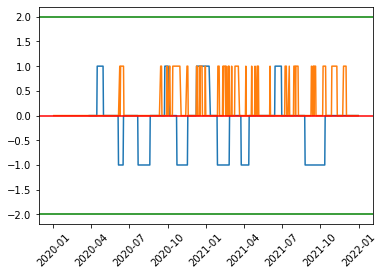

In [140]:
data['all trades'] = data['Trades short'] + data['Trades long']
plt.plot(data['all trades'])
plt.plot(data['ADF lim'])
plt.xticks(rotation='45')
plt.axhline(y=0, color='r')
plt.axhline(y=2, color='g')
plt.axhline(y=-2, color='g')
plt.show()

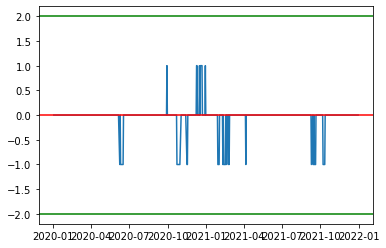

In [141]:
data['adf trades'] = data['all trades'].copy().where((np.abs(data['all trades'])==1) & (data['ADF lim'] == 1)).fillna(0)
plt.plot(data['adf trades'])
plt.axhline(y=0, color='r')
plt.axhline(y=2, color='g')
plt.axhline(y=-2, color='g')
plt.show()

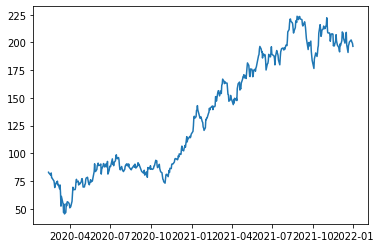

In [142]:
plt.plot((data['s2']-data["Hedge Ratio"]*data['s1']))
plt.show()

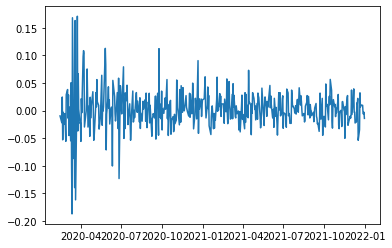

In [143]:
plt.plot((data['s2']-data["Hedge Ratio"]*data['s1']).pct_change())
plt.show()

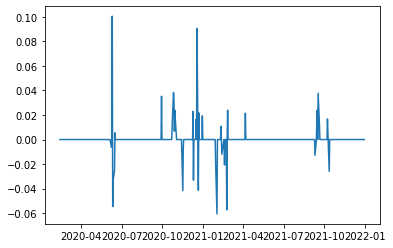

In [144]:
plt.plot((data['s2']-data["Hedge Ratio"]*data['s1']).pct_change().shift(-1)*data['adf trades'])
plt.show()

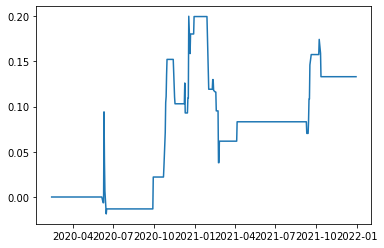

In [145]:
plt.plot(((((data['s2']-data["Hedge Ratio"]*data['s1']).pct_change()).shift(-1))*data['adf trades']).cumsum())
plt.show()